# Exploring outbreaks in India using geopandas

## Outline

In this notebook, the outbreaks of different diseases in India will be explored. Outbreak data by district is merged with the geospatial information of each district to map outbreaks. Furthermore the time evolution of outbreaks can also be mapped.


## Background

Disease outbreak data for India was downloaded from the [Integrated Disease Surveillance Program](https://idsp.nic.in/) in the form of weekly reports in .pdf format. The dataset spans 2009 to present day and is extracted from the .pdf files using `idsp_parser.py`. It is then merged with district data from [Global Administrative Area Maps](https://gadm.org) to form a _master_ geopandas dataframe which has all the information for plotting.

# Cleaning up the data

The IDSP_parser.py program returns a .csv file of outbreaks. However, further processing is required to clean the dataset. These steps are:

* Consolidate duplicated reporting
* Convert string columns to numeric, datetime and other datatypes
* Merging outbreak DataFrame with GeoDataFrame to connect the outbreak data with geospatial information

After these basic steps are complete, then the data can be queried and plotted.

## Putting the data together

First we import the necessary packages. Then we load the two dataframes.

In [1]:
import geopandas as gpd
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy as sp
from datetime import datetime
import shapely as sh
%matplotlib notebook

In [2]:
outbreaks = pd.read_csv("IDSP_data.csv")
IND_2 = gpd.read_file("/data/datasets/Projects/PODCAST/country_district_shape_files/INDIA/gadm36_IND_2.shp")

Lets explore these datasets. _outbreaks_ has text information regarding outbreaks; when, where, what, how many and current status. There is also a comments field which contains potentially useful but unstructured data.

Count the rows with the same ID_code.

In [9]:
outbreaks[outbreaks.duplicated('ID_code') == False]#.groupby(['state','district']).count()

,Unnamed: 0,ID_code,state,district,disease,cases,deaths,start_date,report_date,status,comments,raw
0,0,AS/NGO/2019/05/0111,Assam,Nagaon,?,14,00,02-02-19,02-02-19,Under Surveillance,"Cases reported from Village Pub Kandulimari, ...",AS/NGO/2019/05/0111 Assam Nagaon Chickenpox 14...
1,1,BH/MZP/2019/05/0112,Bihar,Muzaffarpur,?,08,01,31-01-19,01-02-19,Under Surveillance,"Cases reported from Village Muradpur W.No 6, ...",BH/MZP/2019/05/0112 Bihar Muzaffarpur Chickenp...
2,2,BH/GPG/2019/05/0113,Bihar,Gopalganj,?,14,00,30-01-19,11-02-19,Under Surveillance,"Cases reported from Village Bathani Tola, Gam...",BH/GPG/2019/05/0113 Bihar Gopalganj Chickenpox...
3,3,CT/JAN/2019/05/0114,Chhattisgarh,Janjgir-Champa,Food Poisoning,22,00,28-01-19,31-01-19,Under Control,"Cases reported from Village laxmanbhanta, SHC...",CT/JAN/2019/05/0114 Chhattisgarh Janjgir Food ...
4,4,DN/DNH/2019/05/0115,Dadra and Nagar Haveli,Dadra and Nagar Haveli,?,07,00,28-01-19,28-01-19,Under Surveillance,"Cases reported from Village Silvassa City, Bl...",DN/DNH/2019/05/0115 Dadra And Nagar Haveli Dad...
...,...,...,...,...,...,...,...,...,...,...,...,...
1132,1178,UP/HRD/2016/9/0462,Uttar Pradesh,Hardoi,?,12,00,18-02-16,?,Under Surveillance,"Cases reported from Village/SC Malhera, CHC/B...",UP/HRD/2016/9/0462 Uttar Pradesh Hardoi Chicke...
1133,1179,UP/PRT/2016/9/0463,Uttar Pradesh,Pratapgarh,Measles,06,00,15-02-16,?,Under Surveillance,"Cases reported from Village Chotka Harriya, S...",UP/PRT/2016/9/0463 Uttar Pradesh Pratapgarh Su...
1134,1180,UP/SID/2016/9/0464,Uttar Pradesh,Siddharth Nagar,?,20,00,17-02-16,?,Under Surveillance,"Cases reported from Village Chotka Harriya, S...",UP/SID/2016/9/0464 Uttar Pradesh Siddharth Nag...
1135,1181,UP/SID/2016/9/0465,Uttar Pradesh,Siddharth Nagar,?,20,00,22-02-16,?,Under Control,Cases reported from Villages Devbhariya and B...,UP/SID/2016/9/0465 Uttar Pradesh Siddharth Nag...


In [ ]:
outbreaks[outbreaks.duplicated('cases',keep=False) == False]#.groupby(['state','district']).count()

In [ ]:
set(outbreaks.disease)

__ISSUE:__ The post 2016 records with codified ID_codes are easy to find followup reports for. However the pre 2016 records reuse the serial numbers each week resulting in a 100s of repeats. This could be solved only recording propper ID codes in the ID code column. Also a more sophisticated matching routine could be used to find same day same disease same location and use that... We could also retrospectively generate ID codes for the pre 2016 records, which could be neat.

Any value which was not found when creating the dataframe has been replaced with a ?. One way to handle this is to drop all records that contain? Another is to go through and format the columnns correctly. The latter is better as it carries more information.

We would like to

* Make the cases and deaths field to integer
* Make the dates into datatime object

Using `apply` apply the `.to_numeric()` method along the case and death columns. Errors are coerced, meaning failure results in a NAN value which is then dropped. `lambda` function is used here in order to set the errors='coerce'.

In [10]:
outbreaks[['cases','deaths']] = outbreaks[['cases','deaths']].apply(lambda x : pd.to_numeric(x, errors='coerce')).dropna()

similarly `apply` `to_datetime` to convert the dates.

In [11]:
outbreaks[['start_date','report_date']] = outbreaks[['start_date','report_date']].apply(lambda x: pd.to_datetime(x, errors='ignore'))

In [12]:
outbreaks.start_date[0]

'02-02-19'

## Adding the geospatial element

There are a few ways we can connect the outbreak data with the region map of India.

IND_3 is a geopandas, geodataframe which has shape file geometry for the administrative regions of India. As per the following convention,

 * NAME_1 is the state
 * NAME_2 is the district
 * NAME_3 is the city


In [14]:
IND_2

,GID_0,NAME_0,GID_1,NAME_1,NL_NAME_1,GID_2,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.1_1,Nicobar Islands,None,None,District,District,None,IN.AN.NI,"MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8..."
1,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.2_1,North and Middle Andaman,None,None,District,District,None,IN.AN.NM,"MULTIPOLYGON (((92.93898 12.22386, 92.93916 12..."
2,IND,India,IND.1_1,Andaman and Nicobar,None,IND.1.3_1,South Andaman,None,None,District,District,None,IN.AN.SA,"MULTIPOLYGON (((92.47972 10.52056, 92.47945 10..."
3,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.1_1,Anantapur,"Anantpur, Ananthapur",None,District,District,None,IN.AD.AN,"POLYGON ((77.71420 13.76079, 77.71314 13.75074..."
4,IND,India,IND.2_1,Andhra Pradesh,None,IND.2.2_1,Chittoor,Chitoor|Chittor,None,District,District,None,IN.AD.CH,"POLYGON ((78.46293 12.63537, 78.46190 12.63228..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661,IND,India,IND.36_1,West Bengal,None,IND.36.16_1,Pashchim Medinipur,Paschim Medinipur,None,District,District,None,IN.WB.WM,"POLYGON ((87.22874 21.95608, 87.22562 21.95712..."
662,IND,India,IND.36_1,West Bengal,None,IND.36.17_1,Purba Medinipur,Purba Medinipur,None,District,District,None,IN.WB.EM,"MULTIPOLYGON (((87.98972 22.21750, 87.99028 22..."
663,IND,India,IND.36_1,West Bengal,None,IND.36.18_1,Puruliya,None,None,District,District,None,IN.WB.PU,"POLYGON ((85.88916 23.15176, 85.88641 23.15335..."
664,IND,India,IND.36_1,West Bengal,None,IND.36.19_1,South 24 Parganas,None,None,District,District,None,IN.WB.PS,"MULTIPOLYGON (((88.01861 21.57278, 88.01889 21..."


Most of the data columns in the IND_2 geodataframe are not populated and therefore not helpful.

## Quick plot

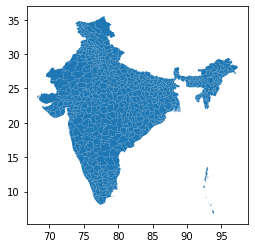

In [16]:
IND_2.plot()

The two data frames can be merged using the dataframe method `.merge()`. By merging the two, we can attach the shape file for the district to the outbreaks in that district.

In this case we are interested in the _state_ and _district_ columns because that is the highest resolution the outbreak dataframe has. State must be included because some districts share the same name but are located in different states.

To do this _NAME\_1_ and _NAME\_2_ are renamded to _state_ and _district_ for compatibility with the outbreak dataframe. Next the multiple level 3 (settlements) data is removed. The dissolve method deals with multiple rows with the same district, keeping the geometry of the first row with a given district.

In [17]:
district_locations = IND_2[['NAME_1','NAME_2','geometry']]\
                    .rename(columns={'NAME_1':'state','NAME_2':'district'})\
                    .dissolve(by=['state','district'],aggfunc='first')
district_locations

geometry
state               district                                                                   
Andaman and Nicobar Nicobar Islands           MULTIPOLYGON (((93.78773 6.85264, 93.78849 6.8...
                    North and Middle Andaman  MULTIPOLYGON (((92.93898 12.22386, 92.93916 12...
                    South Andaman             MULTIPOLYGON (((92.47972 10.52056, 92.47945 10...
Andhra Pradesh      Anantapur                 POLYGON ((77.71420 13.76079, 77.71314 13.75074...
                    Chittoor                  POLYGON ((78.46293 12.63537, 78.46190 12.63228...
...                                                                                         ...
West Bengal         Pashchim Medinipur        POLYGON ((87.22874 21.95608, 87.22562 21.95712...
                    Purba Medinipur           MULTIPOLYGON (((88.03139 22.06056, 88.03139 22...
                    Puruliya                  POLYGON ((85.88916 23.15176, 85.88641 23.15335...
                    South 24 Parganas         MULTIPOLYGON (((88.01861 21.57278, 88.01889 21...
                    Uttar Dinajpur            MULTIPOLYGON (((88.45732 25.59600, 88.45847 25...

[666 rows x 1 columns]

This geodataframe contains the unique names and geometry for each district in India. Now it must be merged with the outbreak data along the state and district columns

## Plot a random district and label it

To plot the districts themselves we can use `gpd.plotting.plot_dataframe()`.

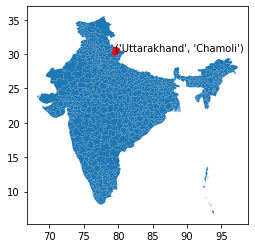

In [18]:
fig, ax = plt.subplots()

# choose a district at random
district = random.choice(district_locations.index)

gpd.plotting.plot_dataframe(district_locations,
                            ax=ax,
                           )
gpd.plotting.plot_polygon_collection(ax, district_locations.loc[[district],'geometry'],
                                     color='red'
                                    )

# district_locations.loc[[district]].centroid
plt.annotate(s=district, xy=(district_locations.loc[[district]].centroid.x,
                             district_locations.loc[[district]].centroid.y
                            )
            )

plt.show()

# Merge outbreaks with geospatial data on state and district columns

In [21]:
master = district_locations.merge(outbreaks,on=['state','district'])

save to file for later use

In [27]:
pwd

'/local1/data/scratch'

In [28]:
master.to_file("IND_outbreaks.shp")

# Combination of data sets to map outbreaks

## Plot Cholera outbreaks

Lets plot the total cholera outbreaks. To do this we select the outbreaks that are cholera. Then take only the district and cases field before merging with the district locations. Now we have a composite dataframe that can make 

First lets figure out the total number of cholera cases

In [29]:
outbreaks[outbreaks.disease == 'Cholera'].cases.dropna().sum()

93899.0

The district locations are ready to be merged with the outbreak data. In this case we just need the number of cholera cases so we select those before merging. That gives a consise geodataframe. Note that the geodataframe should be the one calling the merge() method, otherwise the result will be a normal dataframe, and loose its geo prefix and special abilities. This can be rectified it is just not quite so pleasing.

In [24]:
composite = district_locations.merge(
    outbreaks[outbreaks['disease'] == 'Cholera'][['state','district','cases']],
    on=['state','district']
)
print(type(composite))

<class 'geopandas.geodataframe.GeoDataFrame'>


drop nan values and aggregate using .dissolve(). This gives us a single row for each district that contains the geometry and number of cases of cholera only.

In [25]:
cholera_district_cases = composite.dropna().dissolve(by=['state','district'],aggfunc='sum')
print(type(cholera_district_cases))
print(cholera_district_cases.sum())

<class 'geopandas.geodataframe.GeoDataFrame'>
cases    2942.0
dtype: float64


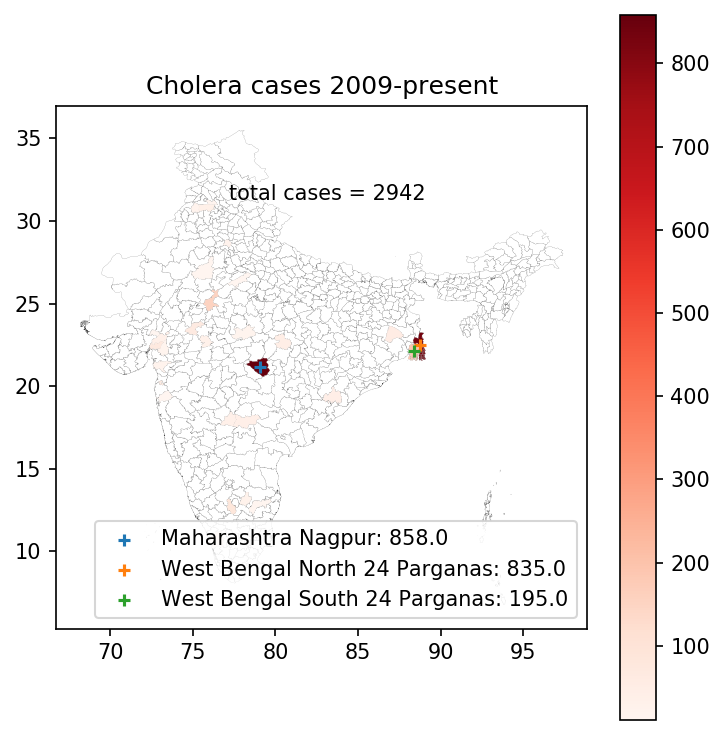

In [26]:
fig, ax = plt.subplots(figsize=(5,5),dpi=150)

IND_2.plot(ax=ax,
           color='white',
           edgecolor='black',
           alpha=1,
           linewidth=0.05,
          )

cholera_district_cases.plot(column = 'cases',
                            cmap='Reds',
                            ax=ax,
                            legend=True,
                           )

plt.title('Cholera cases 2009-present')

# label the 3 most infected districts
for index in cholera_district_cases.nlargest(3,columns='cases').index:
    gpd.plotting.plot_point_collection(ax,
                                       cholera_district_cases.loc[[index]].centroid,
#                                        color='black',
                                       marker='+',
                                       label=" ".join(index)+": "+str(cholera_district_cases.loc[[index]].cases.sum())
                                      )
    
#     plt.annotate(s= " ".join(index),
#                  xy=(cholera_district_cases.loc[[index]].centroid.x,
#                      cholera_district_cases.loc[[index]].centroid.y),
#                  horizontalalignment='left',
#                  verticalalignment='bottom'
#                 )

# get the total bounding box
x0,y0,x1,y1 = cholera_district_cases.total_bounds

# display total cases as an inset
plt.text(x0 + 1  * (x1-x0),
         y0 + 1  * (y1-y0),
         'total cases = '+str(int(cholera_district_cases.cases.sum())),
         horizontalalignment='right',
        )

plt.legend(loc=4)

plt.tight_layout()

plt.show()

Heatmap showing total Cholera cases by district from 2009 - present. The results with later version of the data analysis code seems to produce wildly different results. Which isn't reassuring. A ground truth metric against which the data can be compared would be very useful!

At this point we have some informative data. However it should be noted that this representation shows the total number of outbreaks by district. The districts themselves are not equal and this graphic shows neither the spatial density of cholera nor the infection rate.